# **Setting**

In [ ]:
!pip install torchtext==0.10.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.2 MB/s 
     |████████████████████████████████| 831.4 MB 2.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.0
    Uninstalling torchtext-0.13.0:
      Successfully uninstalled torchtext-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu113 requires torch==1.12.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.9.0 which is incompatible.


In [ ]:
pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 6.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/COMP9444

/content/gdrive/My Drive/COMP9444


In [ ]:
ls

 3_classes_enumerated.csv                           test2_without_trimming.csv
 3_classes_enumerated_text_feature.csv              test2_with_trimming.csv
 4class.csv                                         test_trimming_2.csv
 Copy_of_MultilayeredLSTM_2Trimming_Raymond.ipynb   text_plus_title_input.ipynb
 data_3_classes.csv                                 train2_without_trimming.csv
 data_3.csv                                         train2_with_trimming.csv
 data_neg_neu_pos.csv                               train.csv
 data_text_title.csv                                train_trimming_2.csv
'final data'/                                       trimming_data.csv
 new-base-code-v0.ipynb                             tutorial/
 state_dict.pt                                      using_bidirectional.ipynb


In [ ]:
from datetime import datetime
from tensorboardX import SummaryWriter
import torchtext.legacy as torchtext
from torchtext.vocab import GloVe, vocab
import torch.nn

#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import time
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# **Load Dataset**

Use code-block below if you want to use a dataframe straight from CSV

In [ ]:

# alternative run this code if you want to use CSV as dataframe directly
train = pd.read_csv('train2_with_trimming.csv')
test = pd.read_csv('test2_with_trimming.csv')

train.loc[train['sentiment'] == 'negative', 'sentiment'] = 0
train.loc[train['sentiment'] == 'positive', 'sentiment'] = 1

test.loc[test['sentiment'] == 'negative', 'sentiment'] = 0
test.loc[test['sentiment'] == 'positive', 'sentiment'] = 1

train = train.drop(['Unnamed: 0'], axis=1)
test = test.drop(['Unnamed: 0'], axis=1)

# **Data Pre-Processing**

In [ ]:
train_titles = [x.split() for x in train['Title']] 
train_text = [x.split() for x in train['Text']] 
train_labels = [y for y in train['sentiment']]

test_titles = [x.split() for x in test['Title']] 
test_text = [x.split() for x in test['Text']] 
test_labels = [y for y in test['sentiment']]

In [ ]:
print(f'len_train_titles:{len(train_titles)}, len_train_labels:{len(train_labels)}')
print(f'len_train_text:{len(train_text)}, len_train_labels:{len(train_labels)}')
print(f'len_test_titles:{len(test_titles)}, len_test_labels:{len(test_labels)}')
print(f'len_test_text:{len(test_text)}, len_test_labels:{len(test_labels)}')

len_train_titles:54400, len_train_labels:54400
len_train_text:54400, len_train_labels:54400
len_test_titles:7200, len_test_labels:7200
len_test_text:7200, len_test_labels:7200


In [ ]:
from collections import Counter
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
words = Counter() # Dictionary that will map a word to the number of times it appeared in all the training sentences not text
for i, sentence in enumerate(train['Title']):
  # Each sentences will be stored as a list of words/tokens
  train_titles[i]=[]
  for word in nltk.word_tokenize(sentence):
    words.update([word.lower()])              # This will add to the frequency of the word
    train_titles[i].append(word)
  
for i, sentence in enumerate(train['Text']):
  # The sentences will be stored as a list of words/tokens
  train_text[i]=[]
  for word in nltk.word_tokenize(sentence):
    words.update([word.lower()]) 
    train_text[i].append(word)



In [ ]:
for i, sentence in enumerate(test['Title']):
  test_titles[i]=[]
  for word in nltk.word_tokenize(sentence):
    test_titles[i].append(word)

for i, sentence in enumerate(test['Text']):
  test_text[i]=[]
  for word in nltk.word_tokenize(sentence):
    test_text[i].append(word)


In [ ]:
# Removing the words that only appear once
words = {k:v for k,v in words.items() if v > 1}

# Sorting the words according to the number of appearances, with the most common word being first
words = sorted(words, key=words.get, reverse=True)

# Adding padding and unknown to our vocabulary so that they will be assigned an index
words = ['_PAD','_UNK'] + words

# Dictionaries to store the word to index mappings and vice versa
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

In [ ]:
# convert all the words in all list of titles to 
for i, sentence in enumerate(train_titles):
    # Looking up the mapping dictionary and assigning the index to the respective words
    train_titles[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

for i, sentence in enumerate(train_text):
    # Looking up the mapping dictionary and assigning the index to the respective words
    train_text[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]    

for i, sentence in enumerate(test_titles):
    #mapping
    test_titles[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

for i, sentence in enumerate(test_text):
    #mapping
    test_text[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

In [ ]:
# We find the max tokenized sentence length to decide padding length
#find max length of title
l = 0
l = int(l)
for sentence in train_titles:
  length = len(sentence)
  length = int(length)
  if length > l:
    l = length

print(l)


10


In [ ]:
# We find the max tokenized sentence length to decide padding length
# find max length of text input
l = 0
l = int(l)
for sentence in train_text:
  length = len(sentence)
  length = int(length)
  if length > l:
    l = length

print(l)

41


In [ ]:
# Defining a function that either shortens sentences or pads sentences with 0 to a fixed length
def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

seq_len = 15  # The length that the sentences will be padded/shortened to


train_sentences = pad_input(train_titles, seq_len)
train_text = pad_input(train_text, seq_len)
test_sentences = pad_input(test_titles, seq_len)
test_text = pad_input(test_text, seq_len)

# Converting our labels into numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


# Data Loader

In [ ]:
#split valid and test
split_frac = 0.5 # 50% validation, 50% test
split_id = int(split_frac * len(test_sentences))
val_sentences, test_sentences = test_sentences[:split_id], test_sentences[split_id:]
val_reviewText, test_reviewText= test_text[:split_id], test_text[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

In [ ]:
# use a single dataloader iterable for training data
batch_size = 100
combined_trainData = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_text), torch.from_numpy(train_labels))
combined_trainLoader = DataLoader(combined_trainData, shuffle=True, batch_size=batch_size)

In [ ]:
# use a single dataloader iterable for validation data
combined_valData = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_reviewText), torch.from_numpy(val_labels))
combined_valLoader = DataLoader(combined_valData, shuffle=True, batch_size=batch_size)

In [ ]:
# use a single dataloader iterable for test data
combined_testData = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_reviewText), torch.from_numpy(test_labels))
combined_testLoader = DataLoader(combined_testData, shuffle=True, batch_size=batch_size)

# **Build model**

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
print(device)

cuda


In [ ]:
vocab_size = len(word2idx) + 1
output_size = 2

embedding_dim = 200
hidden_dim = 512
n_layers = 2         # number of layers in the LSTM layer


In [ ]:
vocab_size

1801

## Simple LSTM

In [ ]:
class simple_LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(simple_LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.finalLayer = nn.Linear(200,100) # test
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x1, x2, hidden): 
        
        # Layers for title input
        batch_size = x1.size(0)
        x1 = x1.long()
        embeds = self.embedding(x1)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, -1)
        out1 = out[:,-1]

        # Layers for text input
        batch_size = x2.size(0)
        x2 = x2.long()
        embeds = self.embedding(x2)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, -1)
        out2 = out[:,-1]
        

        # combine input results
        out = out1 + out2
        out = self.sigmoid(out)

        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

# **Training**

### Simple LSTM train and evaluation

In [ ]:
#LSTM
model = simple_LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

simple_LSTM(
  (embedding): Embedding(1801, 200)
  (lstm): LSTM(200, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (finalLayer): Linear(in_features=200, out_features=100, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Hyper-tunable parameters
lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epochs = 5
counter = 0
print_every = 20
clip = 5
valid_loss_min = np.Inf

# for data visualisation section
loss_list = []
acc_list = []
val_acc_list = []
epoch_list = []

model.train()
for i in range(epochs):
    epoch_list.append(i)
    train_losses = []
    val_acces = []
    num_correct = 0
    h = model.init_hidden(batch_size)
    
    for index, (x1, x2, x3) in enumerate(combined_trainLoader):
        # x1 - title input
        # x2 - text input
        # x3 - output label

        counter += 1
        h = tuple([e.data for e in h]) # ?
        input1, input2, labels = x1.to(device), x2.to(device), x3.to(device)
        model.zero_grad()
        output, h = model(input1, input2, h)
        train_loss = criterion(output.squeeze(), labels.float())
        train_losses.append(train_loss.item())
        pred = torch.round(output.squeeze()) #rounds the output to 0/1
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)

        train_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            val_num_correct = 0
            model.eval()
            # running validation dataset
            for index, (val_x1, val_x2, lab) in enumerate(combined_valLoader):
                val_h = tuple([each.data for each in val_h])
                val_input1, val_input2, lab = val_x1.to(device), val_x2.to(device), lab.to(device)
                out, val_h = model(val_input1, val_input2, h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                val_pred = torch.round(out.squeeze())                           #rounds the output to 0/1
                val_correct_tensor = val_pred.eq(lab.long().view_as(val_pred))
                val_correct = np.squeeze(val_correct_tensor.cpu().numpy())
                val_num_correct += np.sum(val_correct)
            
            val_acc = val_num_correct/len(combined_valLoader.dataset)
            val_acces.append(val_acc)
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(train_loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Val accuracy: {:.3f}%".format(val_acc*100),
                  )
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    
    epoch_train_loss = np.mean(train_losses)
    loss_list.append(epoch_train_loss)

    print("Train loss: {:.3f}".format(epoch_train_loss))
    train_acc = num_correct/len(combined_trainLoader.dataset)
    print("Train accuracy: {:.3f}%".format(train_acc*100))

    acc_list.append(train_acc)
    epoch_val_acc = np.mean(val_acces)
    val_acc_list.append(epoch_val_acc)



Epoch: 1/5... Step: 20... Loss: 0.381597... Val Loss: 0.318814 Val accuracy: 87.278%
Validation loss decreased (inf --> 0.318814).  Saving model ...
Epoch: 1/5... Step: 40... Loss: 0.298881... Val Loss: 0.319475 Val accuracy: 87.083%
Epoch: 1/5... Step: 60... Loss: 0.438023... Val Loss: 0.328645 Val accuracy: 87.250%
Epoch: 1/5... Step: 80... Loss: 0.311037... Val Loss: 0.318811 Val accuracy: 87.417%
Validation loss decreased (0.318814 --> 0.318811).  Saving model ...
Epoch: 1/5... Step: 100... Loss: 0.315890... Val Loss: 0.331357 Val accuracy: 87.028%
Epoch: 1/5... Step: 120... Loss: 0.359007... Val Loss: 0.324218 Val accuracy: 87.333%
Epoch: 1/5... Step: 140... Loss: 0.323691... Val Loss: 0.311807 Val accuracy: 86.917%
Validation loss decreased (0.318811 --> 0.311807).  Saving model ...
Epoch: 1/5... Step: 160... Loss: 0.320716... Val Loss: 0.303664 Val accuracy: 87.806%
Validation loss decreased (0.311807 --> 0.303664).  Saving model ...
Epoch: 1/5... Step: 180... Loss: 0.378541... 

# **Evaluation**

In [ ]:
# Running the test dataset
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for index, (x1, x2, x3) in enumerate(combined_testLoader):
    h = tuple([each.data for each in h])
    inputs1, inputs2, labels = x1.to(device), x2.to(device), x3.to(device)
    output, h = model(inputs1, inputs2, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze()) #rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
        
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(combined_testLoader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.312
Test accuracy: 87.083%


# **Data Visualization**






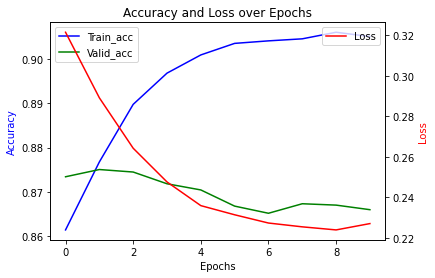

In [ ]:
# Data visualisation
import matplotlib.pyplot as plt

acc_list_numpy = acc_list
val_acc_list_numpy = val_acc_list

fig, ax1 = plt.subplots()

plt.plot(epoch_list, acc_list_numpy, label = 'Train_acc', color = 'b')
plt.plot(epoch_list, val_acc_list_numpy, label = 'Valid_acc', color = 'g')
plt.legend()

ax2 = ax1.twinx()
ax2.plot(epoch_list, loss_list, label='Loss', color = 'r')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax2.set_ylabel('Loss', color='r')

plt.title("Accuracy and Loss over Epochs")
plt.legend()
plt.show()

# **Experimentation**






Comparing loss and accuracy between models using trimmed data

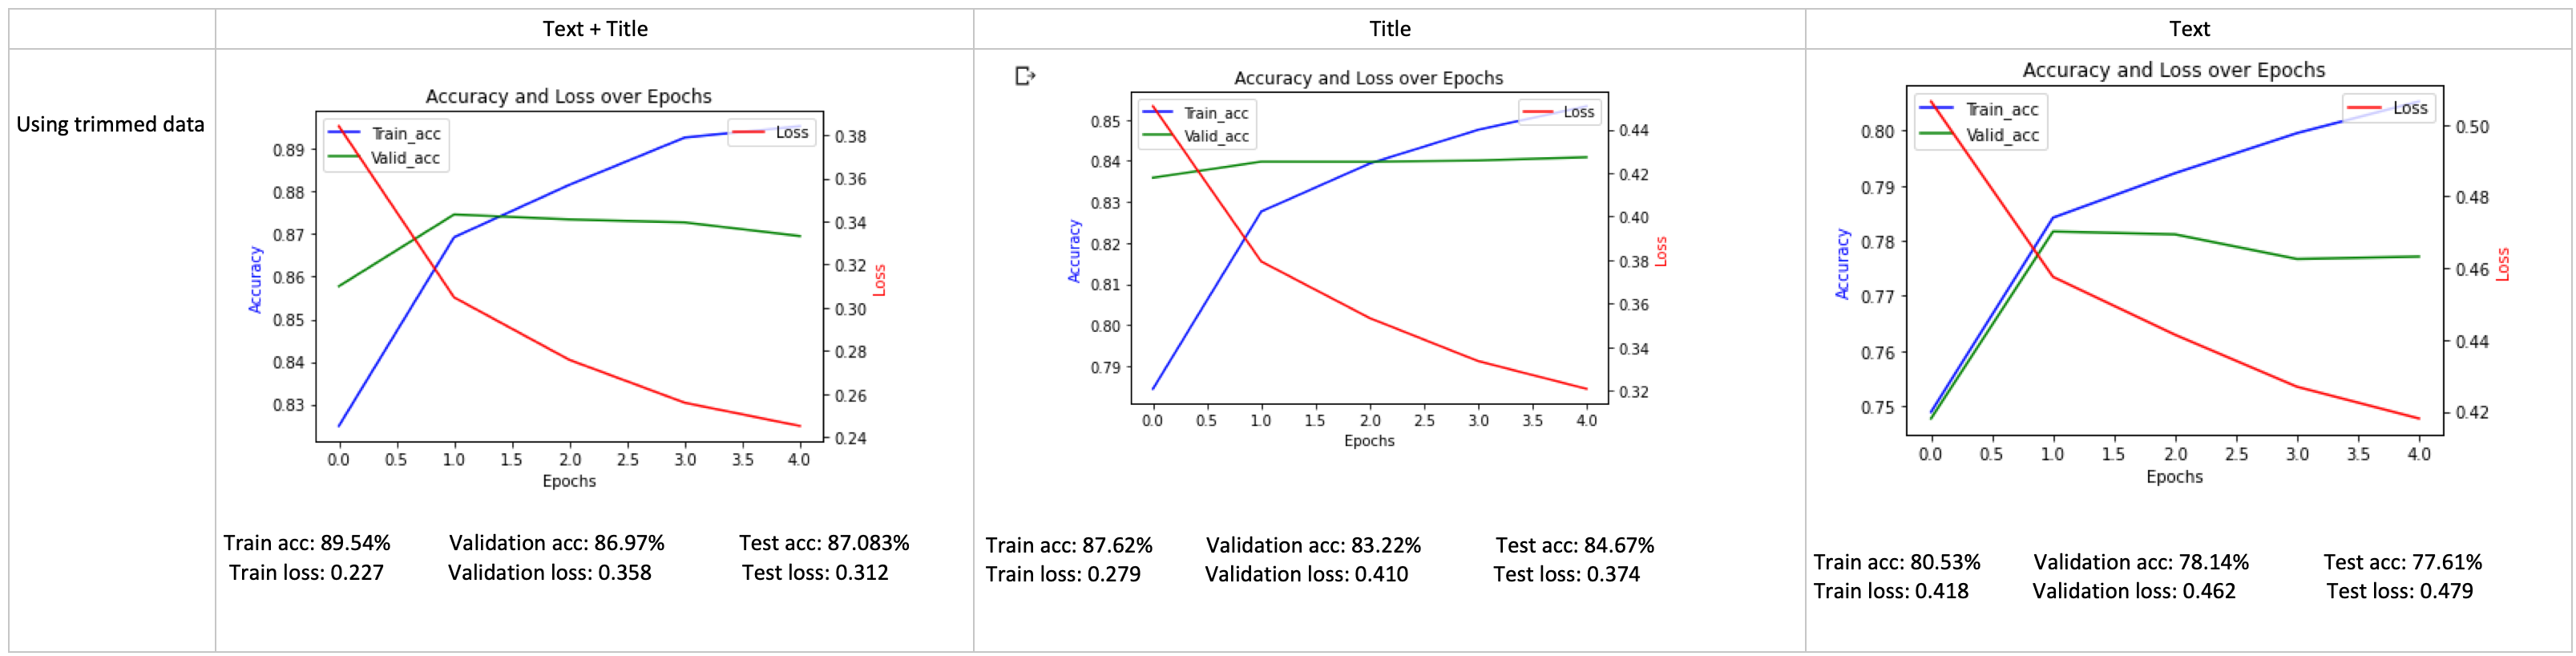

Coding loss and accuracy between models using untrimmed data

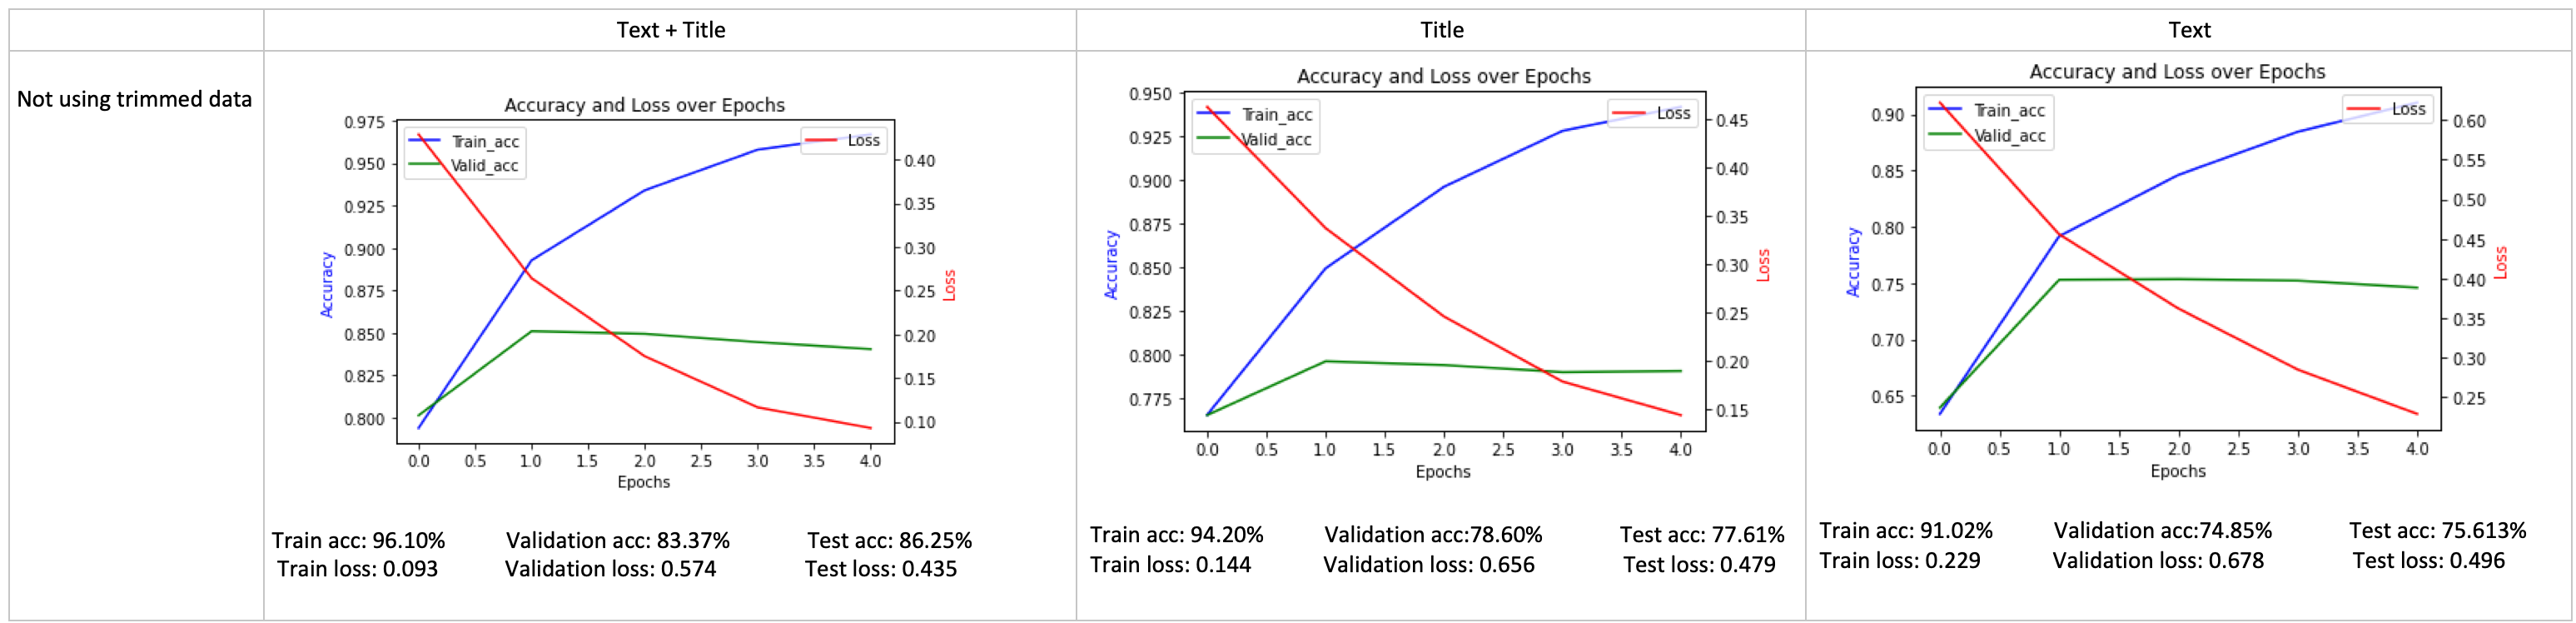